# Fire Atlas Dataset Exploration // Ignitions
#### Exploring the 2016 map with geopandas
Andrew McDonald // CSE 847 // 6 March 2021

In [48]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 1. Explore Large Wildfires Shapefiles


In [4]:
fires = gpd.read_file("large_wildfires/Global_Fire_Atlas_V1_largest_fires_by_continent.shp")
fires.head(5)

,fire_ID,lat,lon,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_,landcover,landcover_,tile_ID,geometry
0,226562,37.3396,-8.5014,267.53,116.68,2003-09-12,255,2003-09-20,263,9,29.73,21.76,5.73,8,northwest,8,Woody savannas,h17v05,"POLYGON ((-8.72245 37.44583, -8.70670 37.44583..."
1,226560,37.2146,-8.6286,285.97,109.27,2003-08-09,221,2003-08-19,231,11,26.00,24.92,3.79,1,north,8,Woody savannas,h17v05,"POLYGON ((-8.72090 37.38750, -8.71041 37.38750..."
2,226077,39.9979,-7.6967,505.05,247.24,2003-07-29,210,2003-08-13,225,16,31.57,21.47,21.19,6,southwest,8,Woody savannas,h17v05,"POLYGON ((-8.06633 40.00000, -8.00106 40.00000..."
3,226098,39.6646,-8.0656,997.46,396.33,2003-07-18,199,2003-08-11,223,25,39.90,23.48,25.88,4,southeast,8,Woody savannas,h17v05,"POLYGON ((-8.09411 39.77500, -8.05616 39.77500..."
4,897775,49.3354,114.8466,4003.13,1051.94,2003-05-01,121,2003-05-09,129,9,444.79,189.98,77.50,3,east,10,Grasslands,h25v04,"MULTIPOLYGON (((115.13239 49.55833, 115.14523 ..."


In [5]:
fires["area"] = fires.area
fires["area"].head(5)


<ipython-input-5-11e8418e757a>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fires["area"] = fires.area


0    0.027264
1    0.029101
2    0.053293
3    0.104733
4    0.495592
Name: area, dtype: float64

In [6]:
fires.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
ctx.providers.keys()

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])

In [62]:
ctx.providers["NASAGIBS"].keys()

dict_keys(['ModisTerraTrueColorCR', 'ModisTerraBands367CR', 'ViirsEarthAtNight2012', 'ModisTerraLSTDay', 'ModisTerraSnowCover', 'ModisTerraAOD', 'ModisTerraChlorophyll'])

In [74]:
providers = {}

def get_providers(provider):
    if "url" in provider:
        providers[provider['name']] = provider
    else:
        for prov in provider.values():
            get_providers(prov)

get_providers(ctx.providers)
providers.keys()

dict_keys(['OpenStreetMap.Mapnik', 'OpenStreetMap.DE', 'OpenStreetMap.CH', 'OpenStreetMap.France', 'OpenStreetMap.HOT', 'OpenStreetMap.BZH', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest.OpenCycleMap', 'Thunderforest.Transport', 'Thunderforest.TransportDark', 'Thunderforest.SpinalMap', 'Thunderforest.Landscape', 'Thunderforest.Outdoors', 'Thunderforest.Pioneer', 'Thunderforest.MobileAtlas', 'Thunderforest.Neighbourhood', 'OpenMapSurfer.Roads', 'OpenMapSurfer.Hybrid', 'OpenMapSurfer.AdminBounds', 'OpenMapSurfer.ContourLines', 'OpenMapSurfer.Hillshade', 'OpenMapSurfer.ElementsAtRisk', 'Hydda.Full', 'Hydda.Base', 'Hydda.RoadsAndLabels', 'MapBox', 'Stamen.Toner', 'Stamen.TonerBackground', 'Stamen.TonerHybrid', 'Stamen.TonerLines', 'Stamen.TonerLabels', 'Stamen.TonerLite', 'Stamen.Watercolor', 'Stamen.Terrain', 'Stamen.TerrainBackground', 'Stamen.TopOSMRelief', 'Stamen.TopOSMFeatures', 'Esri.WorldStreetMap', 'Esri.DeLorme', 'Esri.World

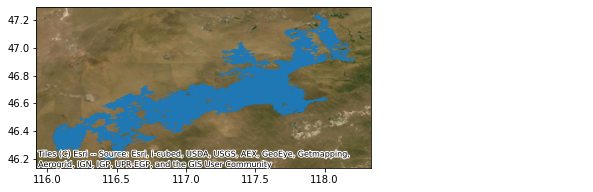

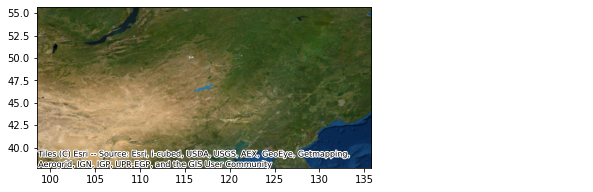

In [106]:
idx = 10
ax = fires.iloc[[idx]].plot(alpha=1)
ctx.add_basemap(ax, crs=fires.crs, source=ctx.providers.Esri.WorldImagery)

minx, miny, maxx, maxy = fires.iloc[[idx]].bounds.T.values
fires.iloc[[idx]].bounds

padx, pady = (maxx - minx)*8, (maxy - miny)*8
ax = fires.iloc[[idx]].plot(alpha=1)
ax.set_xlim(minx-padx, maxx+padx)
ax.set_ylim(miny-pady, maxy+pady)
ctx.add_basemap(ax, crs=fires.crs, source=ctx.providers.Esri.WorldImagery)

# 2. Explore 2016 Ignitions

In [2]:
ignitions = gpd.read_file("2016_wildfires/Global_fire_atlas_V1_ignitions_2016.shp")
ignitions.head(5)

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID,geometry
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06,POINT (-156.41374 20.84379)
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06,POINT (-156.41833 20.83962)
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06,POINT (-156.43708 20.81045)
3,4,20.6271,-156.247,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06,POINT (-156.24786 20.62712)
4,5,19.8063,-155.895,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07,POINT (-155.89512 19.80629)


In [3]:
ignitions.shape

(887221, 19)

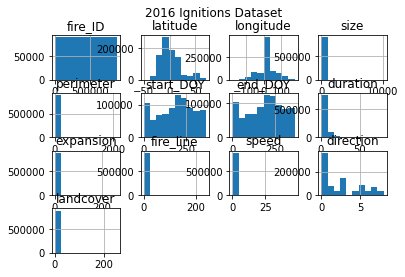

In [4]:
ignitions.hist()
plt.suptitle("2016 Ignitions Dataset\n")
plt.show()

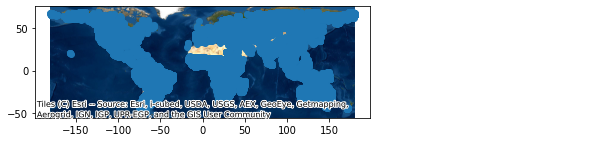

In [9]:
ax = ignitions.plot()
ctx.add_basemap(ax, crs=ignitions.crs, source=ctx.providers.Esri.WorldImagery)

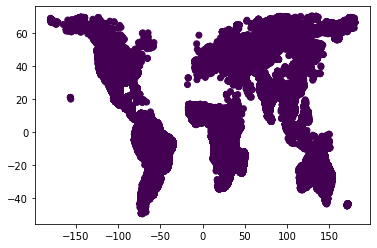

In [12]:
x = ignitions["longitude"]
y = ignitions["latitude"]
c = ignitions["size"]
plt.scatter(x=x, y=y, c=c)
plt.show()

# 3. Explore 2016 Ignitions in USA & Cali

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world["iso_a3"] == "USA"]
usa

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [7]:
ignitions_usa = gpd.overlay(ignitions, usa, how="intersection")
ignitions_usa.head(5)

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,...,direction_s,landcover,landcover_s,tile_ID,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,1,20.8438,-156.413,0.86,4.63,2016-10-26,300,2016-11-02,307,8,...,east,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.41374 20.84379)
1,2,20.8396,-156.418,1.50,6.48,2016-10-28,302,2016-11-02,307,6,...,southeast,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.41833 20.83962)
2,3,20.8105,-156.437,0.43,2.78,2016-11-29,334,2016-11-29,334,1,...,none,12,Croplands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.43708 20.81045)
3,4,20.6271,-156.247,18.65,30.56,2016-02-16,47,2016-02-20,51,5,...,northwest,7,Open shrublands,h03v06,326625791,North America,United States of America,USA,18560000.0,POINT (-156.24786 20.62712)
4,5,19.8063,-155.895,7.72,12.96,2016-03-20,80,2016-03-25,85,6,...,southeast,7,Open shrublands,h03v07,326625791,North America,United States of America,USA,18560000.0,POINT (-155.89512 19.80629)


In [8]:
ignitions_usa.shape

(11524, 24)

In [53]:
ignitions_usa.to_file("2016_wildfires/usa_2016_ignitions.shp")

<ipython-input-53-0224940118a5>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ignitions_usa.to_file("usa_2016_ignitions.shp")


In [14]:
states = gpd.read_file("us_states/tl_2020_us_state.shp")
cali = states[states["STUSPS"] == "CA"]
cali

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
13,4,9,06,01779778,06,CA,California,00,G4000,A,403671196038,20294133830,+37.1551773,-119.5434183,"MULTIPOLYGON (((-124.13656 41.46445, -124.1378..."


In [15]:
ignitions.crs, usa.crs, cali.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4269>
 Name: NAD83
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Isla

In [17]:
cali = cali.to_crs("epsg:4326")
cali.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
ignitions_cali = gpd.overlay(ignitions, cali, how="intersection")
ignitions_cali.head(5)

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,...,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,8,41.8938,-122.979,20.37,40.74,2016-08-28,241,2016-09-12,256,16,...,CA,California,00,G4000,A,403671196038,20294133830,+37.1551773,-119.5434183,POINT (-122.97924 41.89378)
1,9,41.8771,-123.036,17.58,34.26,2016-08-28,241,2016-09-11,255,15,...,CA,California,00,G4000,A,403671196038,20294133830,+37.1551773,-119.5434183,POINT (-123.03670 41.87711)
2,10,41.8688,-123.031,6.65,17.59,2016-08-28,241,2016-09-06,250,10,...,CA,California,00,G4000,A,403671196038,20294133830,+37.1551773,-119.5434183,POINT (-123.03185 41.86878)
3,11,41.8729,-123.090,58.52,52.78,2016-08-29,242,2016-09-10,254,13,...,CA,California,00,G4000,A,403671196038,20294133830,+37.1551773,-119.5434183,POINT (-123.09023 41.87294)
4,12,41.9063,-122.964,7.72,17.59,2016-08-31,244,2016-09-12,256,13,...,CA,California,00,G4000,A,403671196038,20294133830,+37.1551773,-119.5434183,POINT (-122.96412 41.90628)


In [19]:
ignitions_cali.shape

(195, 33)

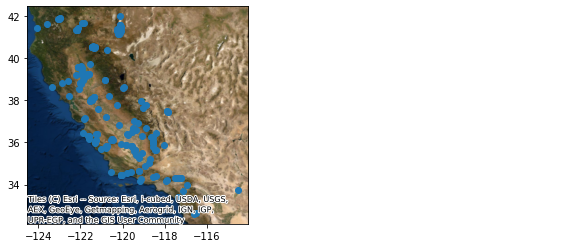

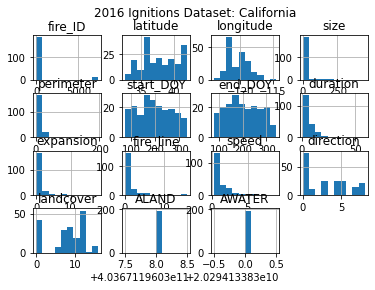

In [21]:
ax = ignitions_cali.plot()
ctx.add_basemap(ax, crs=ignitions_cali.crs, source=ctx.providers.Esri.WorldImagery)
ignitions_cali.hist()
plt.suptitle("2016 Ignitions Dataset: California\n")
plt.show()

In [52]:
ignitions_cali.columns


Index(['fire_ID', 'latitude', 'longitude', 'size', 'perimeter', 'start_date',
       'start_DOY', 'end_date', 'end_DOY', 'duration', 'expansion',
       'fire_line', 'speed', 'direction', 'direction_s', 'landcover',
       'landcover_s', 'tile_ID', 'REGION', 'DIVISION', 'STATEFP', 'STATENS',
       'GEOID', 'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

# 4. Preliminary ML Model on USA

In [34]:
X_usa = ignitions_usa[['latitude', 'longitude', 'start_DOY', 'end_DOY', 'expansion',
                       'fire_line', 'speed', 'direction', 'landcover']].values
y_usa = ignitions_usa[['size']]
X_usa.shape, y_usa.shape

((11524, 9), (11524, 1))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_usa, y_usa, test_size=0.3, random_state=847)
[arr.shape for arr in [X_train, X_test, y_train, y_test]]

[(8066, 9), (3458, 9), (8066, 1), (3458, 1)]

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std, X_test_std = scaler.transform(X_train), scaler.transform(X_test)

In [50]:
for Model in [LinearRegression, Ridge, Lasso]:
    model = Model()
    model.fit(X_train_std, y_train)
    y_hat = model.predict(X_test_std)
    print(f"\nModel: {Model}")
    print(mean_squared_error(y_test, y_hat))
    # print(y_hat[:5], y_test[:5])



Model: <class 'sklearn.linear_model._base.LinearRegression'>
122.52273300269273

Model: <class 'sklearn.linear_model._ridge.Ridge'>
122.49631618657962

Model: <class 'sklearn.linear_model._coordinate_descent.Lasso'>
127.89270384880118
